# Constrained optimization: equality and inequality constraints

### David Íñiguez and Jaume Sanchez

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Note that we have reused an algorithm from an algebra practice (Numerical Linear Algebra) where KKT was also used for a minimization problem

Functions to generate a set of points and to plot them (we consider each label has the same number of points)

In [ ]:
def generate_points (n, separable = True):
    m1 = [0.,0.]; s1 = [[1,-0.9],[-0.9,1]]
    n_label1 = int(n/2)
    points1 = np.random.multivariate_normal(m1, s1, size=n_label1)
    if separable == True:
        m2 = [3.,6.]; s2 = [[1,0],[0,1]] # Separable dataset
    else:
        m2 = [1.,2.]; s2 = [[1,0],[0,1]] # Non-separable dataset
    n_label2 = n - n_label1
    points2 = np.random.multivariate_normal(m2, s2, size=n_label2)
    points = np.concatenate((points1,points2))
    return points

def plot_points(points,n):
    plt.scatter(points[:int(n/2),0],points[:int(n/2),1], c='r')
    plt.scatter(points[int(n/2):,0], points[int(n/2):,1],c='b')
    plt.show()

Function to get bot X and Y matrices

In [ ]:
def get_XY (points,n):
    X = np.zeros((2,n))
    y = np.zeros(n)
    for i in range (int(n/2)):
        X[:,i]=points[i]
        y[i]=1
    for i in range (int(n/2),n):
        X[:,i]=points[i]
        y[i]=-1
    Y = np.diag(y)
    #print(X)
    #print(Y)
    return X,Y

Definition of the initial matrices

In [ ]:
def inicial_matrices_final (n, m, p, K, X, Y):
    G = Y@X.T@X@Y
    g = s = np.full (n, -1, dtype = float)
    C = np.concatenate((np.eye(n),-np.eye(n)),axis=1)
    A = np.zeros((n,1))
    for i in range (n): A[i][0] = Y[i][i]
    b = 0
    x = np.random.uniform(low=0, high=K, size=(n,))
    #print (x)
    gamma = np.full (p, 1, dtype = float)
    b = np.zeros(p)
    d = np.zeros(2*n)
    for i in range(n): d[n+i] = -K
    s = np.full (m, 1, dtype = float)
    l = np.full (m, 1, dtype = float)
    #print (C.T,d)

    return A,G,C,d,b,g,x,gamma,s,l

Creation and update of MKKT matrix

In [ ]:
def create_mkkt (G, A, C, S, L, n, p, m):

    row1 = np.concatenate((G,-A,-C,np.zeros((n,m))),axis = 1)
    row2 = np.concatenate((-A.T,np.zeros((p,p)),np.zeros((p,m)),np.zeros((p,m))),axis = 1)
    row3 = np.concatenate((-C.T,np.zeros((m,p)),np.zeros((m,m)),np.eye(m)),axis = 1)
    row4 = np.concatenate((np.zeros((m,n)),np.zeros((m,p)),S,L),axis = 1)
    mkkt = np.concatenate((row1,row2,row3,row4),axis=0)

    return mkkt

def update_mkkt (M, S, L, n, p, m):
    M [n+m+p:,:] = np.concatenate((np.zeros((m,n)),np.zeros((m,p)),S,L),axis = 1)
    return M

$F(z)$ in general case

In [ ]:
def F (z, G,g,A,C,b,s,d):
    r1 = G@z[0] + g - A@z[1] - C@z[2]
    #for i in range (len(r1)): r.append(r1[i])

    r2 = b - A.T@z[0]
    #for i in range (len(r2)): r.append(r2[i])

    r3 = s + d - C.T@z[0]
    #for i in range (len(r3)): r.append(r3[i])

    r4 = [x*y for x,y in zip(z[2],z[3])]
    #for i in range (len(z[2])):
        #r4.append(float(z[2][i] * z[3][i]))

    r = np.concatenate((r1,r2,r3,r4))

    return r

Functions that creates we matrix we are going to solve using LDLT factorization, that solves the block diagonal (D) and finally that solves it

In [ ]:
from scipy.linalg import ldl

def matrix_6 (G,A,C,Linv,S,n,m,p):

    row1 = np.concatenate((G,-A,-C),axis = 1)
    row2 = np.concatenate((-A.T,np.zeros((p,p)),np.zeros((p,m))),axis=1)
    row3 = np.concatenate((-C.T,np.zeros((m,p)),-Linv@S),axis=1)
    out = np.concatenate((row1,row2,row3),axis=0)

    return out

# Algorithm to solve a block diagonal

def LDLT_blockdiag (D, dim, y):
    sol = []
    i = 0
    while i < dim-1:
        #print (i)
        if D[i,i+1] == 0:
            sol.append(y[i]/D[i][i])
            i+=1
        else:
            #print (D[i+1,i])
            #print (D[i,i+1])
            #print (y[i:i+2])
            Daux = np.zeros((2,2))
            Daux[0][0] = D[i][i]; Daux[0][1] = D[i][i+1]; Daux[1][0] = D[i+1][i]; Daux[1][1] = D[i+1][i+1]
            aux = np.linalg.solve (Daux,y[i:i+2])
            sol += list(aux)
            i+=2

    if len(sol) == dim-1:
        sol.append(y[dim-1]/D[dim-1][dim-1])

    return sol


# Solves a system ex * solution = indep using LDLT factorization on ex (C4,C6)

def solve_LDLT (flag, ex, indep, dim):
    L, D, P = ldl(ex, lower=True)

    LP = L[P, :]; U = np.transpose(LP)

    y1 = solve_triangular(LP, np.array(indep)[np.array(P)], lower = True)

    if np.array_equal(D, np.diag(np.diag(D))):
        #y2 = np.zeros(dim)
        #for i in range (dim): y2[i] = y1[i]/D[i][i]
        y2 = (1/np.diagonal(D))*y1
        sol = solve_triangular(U, y2, lower=False)
        sol = np.array(sol)[np.argsort(np.array(P))]

    else:
        #banda = diagonal_form(D, upper = 1, lower= 1)
        #y2 = solve_banded((1,1), banda, y1)
        y2 = LDLT_blockdiag (D, dim, y1)
        if flag == 0:
            sol = solve_triangular(U, y2, lower=False)
            sol = np.array(sol)[np.argsort(np.array(P))]
        if flag == 1:
            sol = np.linalg.solve(L.T, y2)

    return sol,L,D

Definition of the Newton step

In [ ]:
def Newton_step(l,dl,s,ds):
    alp=1;
    idx_l=np.array(np.where(dl<0))

    if idx_l.size>0:
        alp = min(alp,np.min(-l[idx_l]/dl[idx_l]))

    idx_s0=np.array(np.where(ds<0))
    if idx_s0.size>0:
        alp = min(alp,np.min(-s[idx_s0]/ds[idx_s0]))

    return alp

Solution of the MKKT sistem iteratively

In [ ]:
from scipy.linalg import solve_triangular

# Function that solves the algorithm in general case (C5,C6)
def solve_final (n, m, p, A,G,C,d,b,g,x,gamma,s,l):
    eps = 10**(-16)
    cont = 0
    minimum_norm = 1.0

    S = np.diag(s); L=np.diag(l)

    mkkt = create_mkkt (G, A, C, S, L, n, p, m)

    while 1>0:

        #print (minimum_norm)

        if cont == 100: break
        if minimum_norm < eps: break

        S = np.diag(s)
        L = np.diag(l)
        Sinv = np.diag(1/s)
        Linv = np.diag(1/l)

        #print (cont)
        #print (x, g,'\n')

        z = [x,gamma,l,s]

        mkkt = update_mkkt (mkkt, S, L, n, p, m)
        r = F(z,G,g,A,C,b,s,d)

        #mkkt_test = np.zeros((n+m+m, n+m+m))

        #print (mkkt)
        #print (len(r))

        #r=np.array([r_[0], r_[1], r_[2]])

        r1 = r[:n]; r2 = r[n:n+p]; r3=r[n+p:n+p+m]; r4=r[n+p+m:]

        matrix_ldlt = matrix_6 (G,A,C,Linv,S,n,m,p)

        raux = np.concatenate((r1,r2,r3-Linv@r4))

        dz,Lower,Diag = solve_LDLT (0,matrix_ldlt, -raux, n+m+p)

        dx = dz[:n]; dgamma = dz[n:n+p]; dl=dz[n+p:]
        #print (dx)
        ds = -Linv@(r4+S@dl.copy())

        alpha = Newton_step(l,dl,s,ds)

        mu = np.dot(s.T, l.T)/m; mu_ = np.dot((s + alpha*ds).T, l + alpha*dl)/m; sigma = (mu_/mu)**3

        #print (mu, mu_, sigma)

        DS = np.diag(ds); DL = np.diag(dl); e=np.full(m,1)

        prodaux = np.multiply(DS,DL)@e

        r4 += prodaux - sigma*mu*e

        matrix_ldlt = matrix_6 (G,A,C,Linv,S,n,m,p)
        raux = np.concatenate((r1,r2,r3-Linv@r4))
        dz,Lower,Diag = solve_LDLT (1,matrix_ldlt, -raux, n+m+p)
        dx = dz[:n]; dgamma = dz[n:n+p]; dl=dz[n+p:n+m+p]
        ds = -Linv@(r4+S@dl.copy())

        alpha = Newton_step(l,dl,s,ds)

        x += 0.95*alpha*dx
        gamma += 0.95*alpha*dgamma
        l += 0.95*alpha*dl
        s += 0.95*alpha*ds

        cont += 1
        normas = [np.linalg.norm(r1), np.linalg.norm(r2), np.linalg.norm(r3), np.abs(mu)]
        #print (normas)
        minimum_norm = min(normas)
        #print (minimum_norm)

    return x

Implementation of the SVM full algorithm, and plots of the decision boundaries

In [ ]:
def algorithm (n,K, separable):
    X,Y = get_XY(points,n)
    m=2*n
    p=1
    A,G,C,d,b,g,x,gamma,s,l = inicial_matrices_final (n, m, p, K, X, Y)
    '''print ('G\n', G)
    print ('g\n', g)
    print ('A\n', A)
    print ('C\n', C)
    print ('b\n', b)
    print ('d\n', d)'''
    x = solve_final (n, m, p, A,G,C,d,b,g,x,gamma,s,l)
    w = np.zeros(2)
    for i in range (n):
        w += points[i]*Y[i][i]*x[i]
    blist = []
    b1 = []
    b_1 = []
    eps = 10**-7
    for i in range (len(x)):
        if x[i] >= eps:
            aux = Y[i][i]-w@points[i]
            if separable:
                #print (Y[i][i], aux)
                if Y[i][i] == 1:
                    b1.append(aux)
                if Y[i][i] == -1:
                    b_1.append(aux)
            else:
                blist.append(aux)

    if separable:
        b = 0.5*(max(b1) + min(b_1))
    else:
        b = np.mean(blist)

    print ('w = ', w, '\nb = ',b,'\nmax(alpha) = ',max(x))
    return x,w,b

def bound(x,K,w,b):
    return (K-b-w[0]*x)/w[1]

def plot_boundary (x,points,w,b):
    x = np.linspace(min(points[:,0])-0.3,max(points[:,0])+0.3,200)
    y = np.linspace(min(points[:,1])-0.3,max(points[:,1])+0.3,200)
    X, Y = np.meshgrid(x,y)
    plt.plot(x,bound(x,0.,w,b), c='yellow', label='function = 0')
    plt.plot(x,bound(x,1.,w,b), c='r', label='function = 1')
    plt.plot(x,bound(x,-1.,w,b), c='b', label='function = -1')
    plt.scatter(points[:int(n/2),0],points[:int(n/2),1], c='r',label='label=1')
    plt.scatter(points[int(n/2):,0], points[int(n/2):,1],c='b',label='label=-1')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

## Exercise 1

First of all, let us test the algorithm on a small dataset in the separable case

w =  [-0.32684231 -0.35116047] 
b =  1.0328508660812052 
max(alpha) =  0.11506978686937881


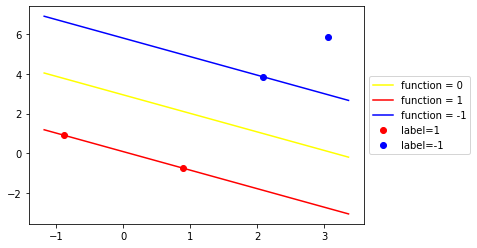

In [ ]:
n=4
points = generate_points (n)
#plot_points(points,n)

alpha,w,b = algorithm (n,1,True)
plot_boundary (alpha,points,w,b)

## Exercise 2

As we could see, the algorithm works for a small dataset. Let us see what happens with bigger datasets (still in the separable case)

w =  [-0.46723108 -0.60019111] 
b =  1.8743055386087626 
max(alpha) =  0.28926712315531566


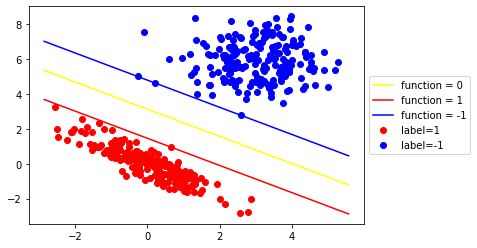

In [ ]:
n=400
points = generate_points (n)
#plot_points(points,n)

alpha,w,b = algorithm (n,1, True)
plot_boundary (alpha,points,w,b)

## Exercise 3

Now that we see the model works, let us see what happens when we modify $K$, that is, the superior bound for the $\alpha$ coefficients.

K = 1e-03
w =  [-0.16528784 -0.24099149] 
b =  0.805387098061253 
max(alpha) =  0.0009999999999969306


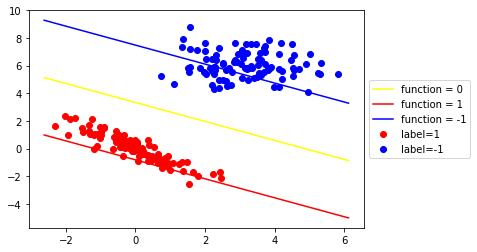




K = 1e+00
w =  [-0.39423001 -0.42721405] 
b =  1.4209648940469612 
max(alpha) =  0.1689645701649547


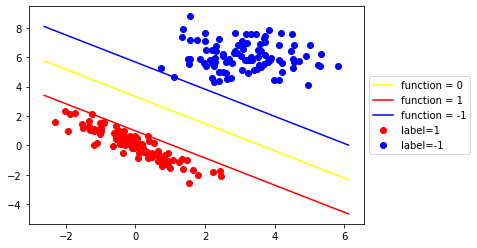




K = 1e+03
w =  [-0.39391189 -0.4275289 ] 
b =  1.422052849401326 
max(alpha) =  0.1688981477025215


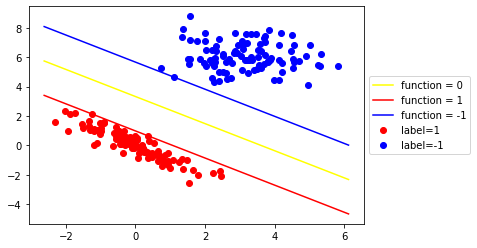




K = 1e+06
w =  [-1.63976855e+08 -3.14942682e+08] 
b =  1056011691.2154973 
max(alpha) =  995061.8141630476


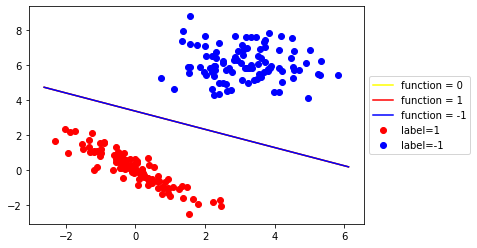




K = 1e+09
w =  [-1.63417202e+11 -2.88959691e+11] 
b =  968022201043.0149 
max(alpha) =  991237023.6444283


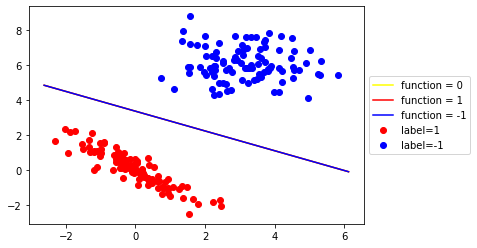




K = 1e+12
w =  [-1.68341664e+14 -3.24080629e+14] 
b =  1086677774835046.6 
max(alpha) =  997866327099.884


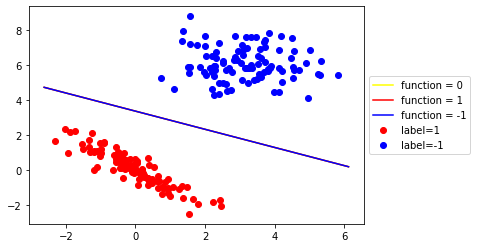

In [ ]:
n=200
points = generate_points (n)
#plot_points(points,n)

K = 0.001

while K <= 10**12:
    print ('K = %.0e' % (K))
    try:
        alpha,w,b = algorithm (n,K, True)
        plot_boundary (alpha,points,w,b)
    except:
        print ('Singular matrix')
    K *= 1000
    print ('\n\n')


As we can see in the plots, for high values of $K$ the decision boundary is not correct. This should not happen, because $K$ is a bound on the values of $\alpha$, and we get that the maximum value of $\alpha$ is $0.16$. For $K = 0.001$ we see that many points are misclassified, that is because the points with an $\alpha$ value greater that $K$ are not considered (misclassified). For intermediate values of $K$ the algorithm performs perfectly, but as well as $K$ increases, the algorithm fails. This is an error due to precission problems, because the decision boundary should be the same as the one that we obtain for smaller values of $K$ ($K=1$, for example)

## Exercise 4

Here we deal with the non separable case. It is normal to obtain misclassifications in this part.

K = 1e-03
w =  [-0.10627217 -0.19206214] 
b =  0.2634290048036132 
max(alpha) =  0.0009999999999996837


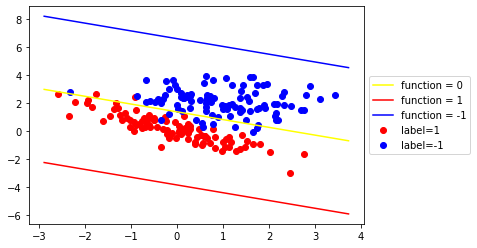




K = 1e+00
w =  [-1.66473977 -1.95526448] 
b =  2.015435134935401 
max(alpha) =  1.0


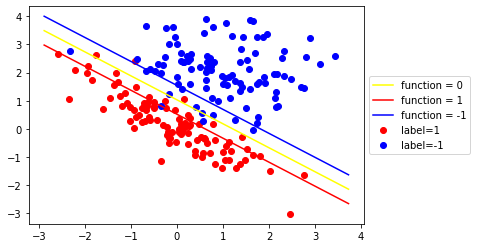




K = 1e+03
w =  [-2.44232127 -2.71272834] 
b =  2.7463578566746425 
max(alpha) =  1000.0


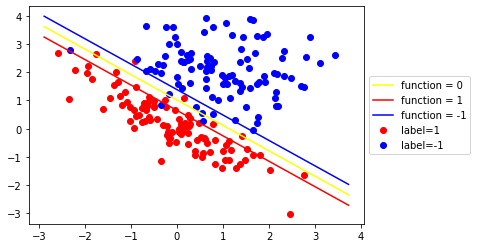




K = 1e+06
w =  [-2.44232127 -2.71272834] 
b =  2.7463578547134784 
max(alpha) =  1000000.0


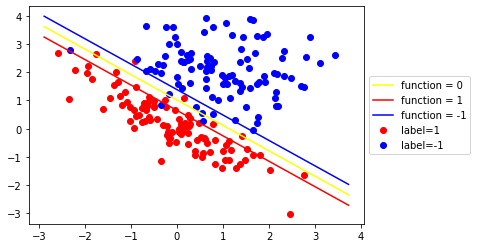




K = 1e+09
w =  [-5.40583591e+10 -9.99807093e+10] 
b =  136573887290.75397 
max(alpha) =  999563148.2775024


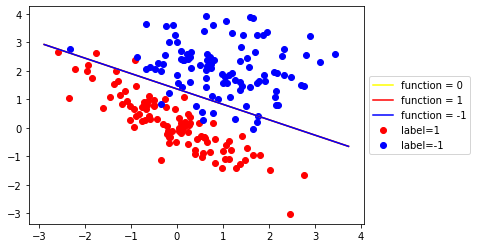




K = 1e+12
w =  [-4.53997891e+13 -1.03308198e+14] 
b =  136500595771477.56 
max(alpha) =  999397744457.7357


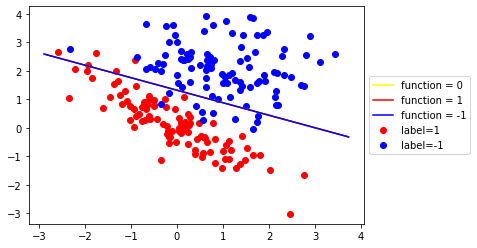

In [ ]:
n=200
points = generate_points (n,separable=False)
#plot_points(points,n)

K = 0.001

while K <= 10**12:
    print ('K = %.0e' % (K))
    try:
        alpha,w,b = algorithm (n,K, False)
        plot_boundary (alpha,points,w,b)
    except:
        print ('Singular matrix')
    K *= 1000
    print ('\n\n')


Here we can see that in the non-separable case the algorithm has a little more trouble working correctly due to erroneous classifications, because the alphas are much larger and the bound ($K$) is very relevant.
So the larger $K$ is, the more restrictive the algorithm is, and this manifests itself in that the larger $K$ is, the fewer errors are allowed, resulting in the margins becoming narrower. Also, for very large values of $K$, as in the separable case, the algorithm works worse due to precision errors.